In [59]:
import geopandas as gpd
import requests
import time
import shapely
import geopandas_osm.osm
import numpy as np
import descartes as d
import math
import fiona
import pickle
%matplotlib inline

In [60]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]
/Users/juliuspark/Library/Python/2.7/lib/python/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


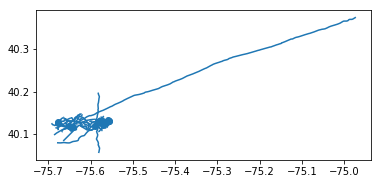

In [5]:
leftbound = -75.6768
rightbound = -75.5590
upperbound = 40.1321
lowerbound = 40.1166
bbox = [(leftbound,lowerbound ), (rightbound,lowerbound), (rightbound,upperbound), (leftbound,upperbound)]
poly = shapely.geometry.Polygon(bbox)
df = geopandas_osm.osm.query_osm('way', poly, recurse='down')
df.plot()

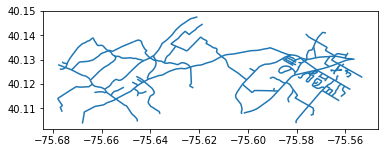

In [6]:
arr=["highway","residential", "primary", "secondary","tertiary","unclassified", "cycleway"]
df=df[df.highway.isin(arr)]
df.plot()


In [68]:
newdata = gpd.GeoDataFrame()
newdata["street name"]=None
newdata["geometry"]=None
streetnewdata = gpd.GeoDataFrame()
streetnewdata["street name"]=None
streetnewdata["geometry"]=None
elev_point_data = gpd.GeoDataFrame()
elev_point_data["elevation"]=None
elev_point_data["geometry"]=None
junctions = gpd.GeoDataFrame()
junctions["geometry"]=None

In [69]:
elevations = load_obj("elevations")

In [70]:
all_coords_list = []
for geometry in df["geometry"]:
    for coord in geometry.coords:
        all_coords_list.append(coord)

In [71]:
def is_intersection(val):
    num_matches = 0
    for i in all_coords_list:
        if val == i:
            num_matches +=1
    
    if(num_matches > 1):
        return True
    else:
        return False
def is_bend(coord, a, b):
    a = get_vector(a, coord)
    b = get_vector(b, coord)
    anorm = math.sqrt(dot(a, a))
    bnorm = math.sqrt(dot(b, b))
    theta = math.acos(dot(a, b)/(anorm*bnorm))
    if(theta > 1.57):
        return False
    else:
        return True
def get_elev_diff(point1, point2):
        return get_elev(point1)-get_elev(point2)
def get_elev(point):
    if(point in elevations):
        return elevations[point]
    else:
        rqstring = "https://maps.googleapis.com/maps/api/elevation/json?locations="+str(point[0])+","+str(point[1])
        elevation=requests.get(rqstring)
        try:
            elev = elevation.json()["results"][0]["elevation"]
            elevations[point] = elev
            time.sleep(.1)
            return elev
        except:
            print elevation.json()
            time.sleep(.1)
            return 0
        
def distance(point1, point2):
    return math.hypot(point2[0]-point1[0], point2[1]-point1[1])
def dot(a, b):
    return float((a[0]*b[0])+(a[1]*b[1]))
def get_vector(point, origin):
    return (point[0]-origin[0], point[1]-origin[1])
def get_anchor_point(point1, point2, elev_diff):
    xv = get_vector(point1, point2)[0]
    yv = get_vector(point1, point2)[1]
    anchor = (-yv, xv)
    anchor = [i*elev_diff/distance(point1, point2) for i in anchor] 
    return (point1[0]+anchor[0], point1[1]+anchor[1])
def reproject_segment(seg, anchor, end, elev_diff, elev1, elev2):
    #print "Beginning points: ",anchor, seg, end
    if(end[0] >= anchor[0]):
        coeff = -1
    elif(end[0] < anchor[0]):
        coeff = 1
    new_points = [anchor]
    cur_point_elev = get_elev(anchor)
    cur_point_elev_diff = coeff*round((cur_point_elev-min(elev1, elev2))*.0005,7)
    if(cur_point_elev_diff != 0.0):
        p = get_anchor_point(anchor,end, cur_point_elev_diff)
        elev_point_data.loc[elev_point_data.shape[0]] = [cur_point_elev, shapely.geometry.point.Point(p)]
        new_points.append(p)
    print(cur_point_elev_diff)
    
    distance_arr = []
    for point in seg:
        a = get_vector(point, anchor)
        b = get_vector(end, anchor)
        project_point = point
        try:
            c = dot(a, b)/dot(b,b)
        except:
            continue
        c = [c*i for i in b]
        p = (anchor[0]+c[0], anchor[1]+c[1])
        distance_arr.append(distance(p, anchor))
        cur_point_elev = get_elev(point)
        cur_point_elev_diff = coeff*round((cur_point_elev-min(elev1, elev2))*.0005,7)
        p = get_anchor_point(p,end, cur_point_elev_diff)
        elev_point_data.loc[elev_point_data.shape[0]] = [cur_point_elev, shapely.geometry.point.Point(p)]
        new_points.append(p)
    
    
    
    zipped = zip(new_points, distance_arr)
    sorted_zip = sorted(zipped, key=lambda pair: pair[1])
    new_points = [a[0] for a in sorted_zip]
    
    cur_point_elev = get_elev(end)
    cur_point_elev_diff = coeff*round((cur_point_elev-min(elev1, elev2))*.0005,7)
    print(cur_point_elev_diff)
    if(cur_point_elev_diff != 0.0):
        p = get_anchor_point(end,anchor, -1*cur_point_elev_diff)
        elev_point_data.loc[elev_point_data.shape[0]] = [cur_point_elev, shapely.geometry.point.Point(p)]
        new_points.append(p)
    
    
    new_points.append(end)
    
    #print "Projected points: ", new_points
    return new_points
def append_segment(name, seg_arr):
    if(len(seg_arr) > 2):
        poly = shapely.geometry.Polygon(seg_arr[:][:])
        line = shapely.geometry.LineString(seg_arr[:])
        try:
            newdata.loc[newdata.shape[0]] = [name, poly]
            streetnewdata.loc[streetnewdata.shape[0]] = [name, line]
            junctions.loc[junctions.shape[0]] = [shapely.geometry.point.Point(seg_arr[0])]
            junctions.loc[junctions.shape[0]] = [shapely.geometry.point.Point(seg_arr[-1])]
        except:
            return

In [72]:
new_index = -1
for index, geometry, name in zip(df.index.values, df["geometry"], df["name"]):
    new_index +=1
    coords = geometry.coords
    coords_list = [i for i in coords]
    intersection_list = [0]
    index=1
    for coord in coords[1:-1]:
        if(is_intersection(coord)):
            intersection_list.append(index)
        #elif(is_bend(coord, coords[0], coords[-1])):
        #    intersection_list.append(index)
        index+=1
    intersection_list.append(int(len(coords)-1))

    print "Length of intersection list:", len(intersection_list)
    if(len(intersection_list) >= 2):
        if(len(intersection_list) == 2):
            point1 = coords_list[intersection_list[0]]
            point2 = coords_list[intersection_list[1]]
            elev1 = get_elev(point1)
            elev2 = get_elev(point2)
            elev_diff=round((elev1-elev2)*.0001,7)
            seg_arr = reproject_segment(coords_list[1:-2], point1, point2, elev_diff, elev1, elev2)
            append_segment(name, seg_arr)
        else:
            prev_index = 0    
            for i in intersection_list[1:-1]:
                #print "section from point ", coords[prev_index], "to point", coords[i], ":",
                point1 = coords_list[prev_index]
                point2 = coords_list[i]
                elev1 = get_elev(point1)
                elev2 = get_elev(point2)
                elev_diff=round((elev1-elev2)*.0001,7)
                seg_arr = reproject_segment(coords_list[prev_index+1:i-1], point1, point2, elev_diff, elev1, elev2)
                append_segment(name, seg_arr)
                prev_index = i
                

    else:
        elev_diff=round(get_elev_diff(coords[0], coords[1])*.0001,7)
        seg_arr = coords_list  
        anchor = get_anchor_point(coords[0],coords[1], elev_diff)
        seg_arr.append(anchor)
        append_segment(name, seg_arr)


Length of intersection list: 2
0.0
5.86e-05
Length of intersection list: 3
0.0
2.8e-06
Length of intersection list: 2
-0.0
-2.09e-05
Length of intersection list: 5
-2.65e-05
-0.0
-3.13e-05
-0.0
-1.77e-05
-0.0
Length of intersection list: 2
0.0
6.14e-05
Length of intersection list: 2
0.0
4.8e-05
Length of intersection list: 2
0.0
0.0002078
Length of intersection list: 3
-4.09e-05
-0.0
Length of intersection list: 2
0.0
8.74e-05
Length of intersection list: 2
-3.55e-05
-0.0
Length of intersection list: 2
0.0
0.0
Length of intersection list: 2
0.0
0.0005303
Length of intersection list: 2
0.0
3.69e-05
Length of intersection list: 2
0.0001536
0.0
Length of intersection list: 2
0.0
9.13e-05
Length of intersection list: 3
0.0
0.0005305
Length of intersection list: 4
-1.66e-05
-0.0
-5.96e-05
-0.0
Length of intersection list: 2
-2.4e-06
-0.0
Length of intersection list: 4
-0.0012063
-0.0
-0.0004517
-0.0
Length of intersection list: 3
0.0
0.0023884
Length of intersection list: 10
-0.0
-0.0
-4.8e

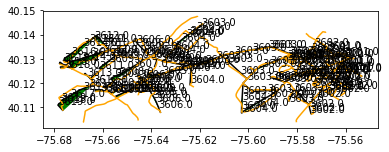

In [64]:
base = streetnewdata.plot(color='white', edgecolor='black')
newdata.plot(ax=base, color='green');
df.plot(ax=base, color="orange")
for elev, point in zip(elev_point_data["elevation"][::10], elev_point_data["geometry"][::10]):
    base.annotate(str(round(elev)), (point.x, point.y))

In [73]:
import os
try:
    os.remove("out_map.geojson")
    os.remove("out_street_map.geojson")
    os.remove("out_elev_map.geojson")
    os.remove("junctions.geojson")
except:
    print("files don't exist")
newdata.to_file("out_map.geojson", driver="GeoJSON")
streetnewdata.to_file("out_street_map.geojson", driver="GeoJSON")
elev_point_data.to_file("out_elev_map.geojson", driver="GeoJSON")
junctions.to_file("junctions.geojson", driver="GeoJSON")
save_obj(elevations, "elevations")
print("files saved")

files saved
